In [ ]:
# installation of packages
#!pip install datasets
#!pip install transformers[torch] accelerate>=0.20.1

In [ ]:
# importation of libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from transformers import TrainingArguments
import torch
from transformers import AutoTokenizer
from torch import nn
from transformers import Trainer,AutoModelForSequenceClassification
from huggingface_hub import notebook_login

### 1. Load Dataset

In [ ]:
emotion= load_dataset('emotion')
emotion

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [ ]:
# logging in huggingface hub
notebook_login()

## 2. EXPLORATORY DATA ANALYSIS
### 2.1.0 Data Overview

In [ ]:
# called the first row of the train dataset
emotion['train'][0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [ ]:
# converting to pandas dataframe
df=emotion['train'].to_pandas()
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [ ]:
# extracting the features of the train-split dataset
feature= emotion['train'].features
feature

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}

In [ ]:
# conditional selecting text and label column of the dataset
df[['text','label']]

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3
...,...,...
15995,i just had a very brief time in the beanbag an...,0
15996,i am now turning and i feel pathetic that i am...,0
15997,i feel strong and good overall,1
15998,i feel like this was such a rude comment and i...,3


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    16000 non-null  object
 1   label   16000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 250.1+ KB


In [ ]:
# making a copy of the train dataset
train_data=df.copy()

In [ ]:
# find the sum of duplicated text
train_data.text.duplicated().sum()

31

In [ ]:
#dropping duplicates
train_data=train_data.drop_duplicates(subset='text',keep='first')

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15969 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    15969 non-null  object
 1   label   15969 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 374.3+ KB


In [ ]:
# checking the statistic distribution of the train dataset
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
label,15969.0,1.564594,1.501035,0.0,0.0,1.0,3.0,5.0


In [ ]:
feature['label'].int2str(4)

'fear'

In [ ]:
id2label={idx:feature['label'].int2str(idx)for idx in range(6)}

In [ ]:
label2id= {k:v for k,v in  id2label.items()}
label2id

{0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}

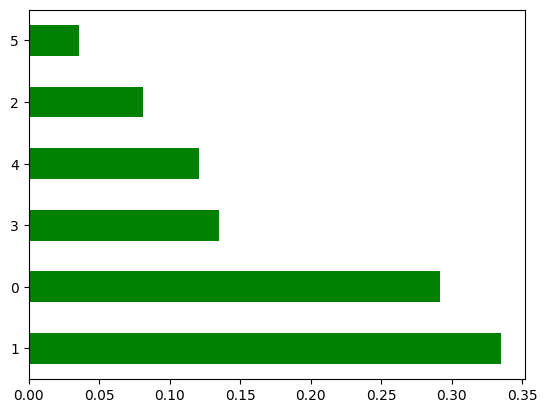

In [ ]:
# checking the frequency of the target
train_data.label.value_counts(normalize=True).plot(kind='barh', color='g');

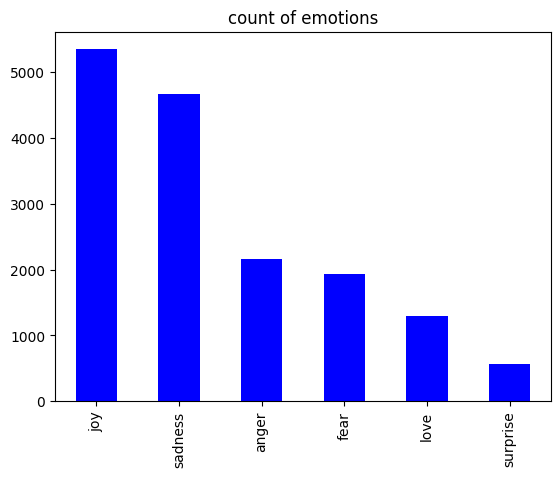

In [ ]:
train_emotion= train_data['label'].map(label2id)
train_emotion.value_counts().plot(kind='bar', color= 'b', title='count of emotions');

- summary, we can observe that the dataset is imbalanced

In [ ]:
emotion['train']=emotion['train'].rename_column('label','labels')

### Dealing with Imbalance dataset

In [ ]:
# dealing imbalance
class_weight= (1-(train_data.label.value_counts().sort_index()/len(df))).values
class_weight

array([0.7085   , 0.665625 , 0.9188125, 0.8653125, 0.8791875, 0.9645   ])

In [ ]:
# converting the frequency of the class weight to deal with imbalance dataset, to tensorflow then to gpu
class_weights=torch.from_numpy(class_weight).float().to('cuda')
class_weights

tensor([0.7085, 0.6656, 0.9188, 0.8653, 0.8792, 0.9645], device='cuda:0')

### Tokenizing

In [ ]:
model_cpt='microsoft/MiniLM-L12-H384-uncased'
tokenizer= AutoTokenizer.from_pretrained(model_cpt)

In [ ]:
def tokenize_text(examples):
    return tokenizer(examples['text'],truncation=True,max_length=512)

In [ ]:
# tokenizing the emotion dataset
emotion= emotion.map(tokenize_text,batched=True)
emotion

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [ ]:
class WeightedLossTrainer(Trainer):
  def compute_loss(self, model, inputs, return_outputs=False):
    # feed inputs to model and extract logits
    outputs= model(**inputs)
    logits= outputs.get('logits')
    # extracting logits
    labels=inputs.get('labels')
# defining loss function with class weight
    loss_function= nn.CrossEntropyLoss(weight=class_weights)
    # computing loss
    loss= loss_function(logits,labels)
    return (loss, outputs) if return_outputs else loss

### modelling

In [ ]:
# instantiating the model
model= AutoModelForSequenceClassification.from_pretrained(model_cpt, num_labels=6,id2label=id2label,label2id=label2id)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from sklearn.metrics import f1_score
def compute_metrics(pred):
  labels= pred.label_ids
  preds= pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average= 'weighted')
  return {'f1':f1}

### hyperparameters

In [ ]:
batch_size= 64
# log the training loss at each epoch
logging_steps= len(emotion['train'])// batch_size
output_dir= 'miniLm-emotions-finetuned'
training_args=TrainingArguments(output_dir=output_dir,
                                num_train_epochs=5,
                                learning_rate=2e-5,
                                per_device_train_batch_size=batch_size,
                                per_device_eval_batch_size=batch_size,
                                weight_decay=0.01,
                                evaluation_strategy='epoch',
                                logging_steps=logging_steps,
                                fp16= True,
                                push_to_hub= True
                                )

In [ ]:
trainer= WeightedLossTrainer(model=model,
                             args=training_args,
                             compute_metrics=compute_metrics,
                             train_dataset=emotion['train'],
                             eval_dataset=emotion['validation'],
                             tokenizer=tokenizer)

In [ ]:
trainer.train()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,F1
1,1.398700,1.067831,0.566990
2,0.917000,0.715381,0.835634
3,0.643500,0.546818,0.878912
4,0.493500,0.440124,0.907110
5,0.429500,0.408116,0.915722


TrainOutput(global_step=1250, training_loss=0.77644375, metrics={'train_runtime': 145.1612, 'train_samples_per_second': 551.111, 'train_steps_per_second': 8.611, 'total_flos': 582422632630272.0, 'train_loss': 0.77644375, 'epoch': 5.0})